# <center>**IROS**<center>

**Libraries**

In [1]:
import matplotlib.pyplot as plt
from pprint import pprint

import mbloodmoon as bm
from dummymoon import image_plot

**Initialization**

In [2]:
mask_file = "../Images_fits/wfm_mask.fits"
simul_data = "../Images_fits/iros_simulation_cam_id00/"

filepaths = bm.simulation_files(simul_data)
pprint(filepaths)

{'cam1a': {'detected': PosixPath('../Images_fits/iros_simulation_cam_id00/cam1a/id00_cam1a_run0_detected_plane.fits'),
           'reconstructed': PosixPath('../Images_fits/iros_simulation_cam_id00/cam1a/id00_cam1a_run0_reconstructed.fits'),
           'sources': PosixPath('../Images_fits/iros_simulation_cam_id00/cam1a/id00_cam1a_run0_sources.fits')},
 'cam1b': {'detected': PosixPath('../Images_fits/iros_simulation_cam_id00/cam1b/id00_cam1b_run0_detected_plane.fits'),
           'reconstructed': PosixPath('../Images_fits/iros_simulation_cam_id00/cam1b/id00_cam1b_run0_reconstructed.fits'),
           'sources': PosixPath('../Images_fits/iros_simulation_cam_id00/cam1b/id00_cam1b_run0_sources.fits')}}


In [3]:
cam = "cam1a"
data_file = "id00_cam1a_run0_reconstructed.fits"

wfm = bm.codedmask(mask_file)
sdl = bm.simulation(simul_data + cam + "/" + data_file)

pprint(sdl.pointings)
pprint(sdl.rotations)

{'x': CoordEquatorial(ra=0.0, dec=45.0),
 'z': CoordEquatorial(ra=180.0, dec=45.0)}
{'x': CoordHorizontal(az=0.0, al=0.0), 'z': CoordHorizontal(az=0.0, al=90.0)}


**Detector and Sky Reconstruction Image**

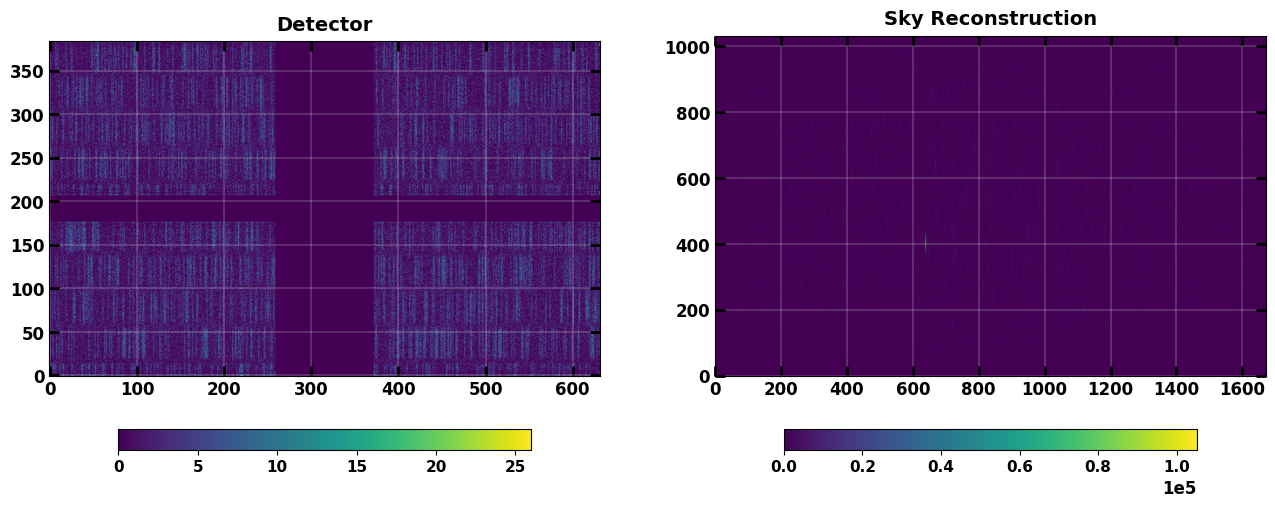

In [4]:
detector, _ = bm.count(wfm, sdl.data)
skyrec = bm.decode(wfm, detector)

image_plot([detector, skyrec],
           ["Detector", "Sky Reconstruction"],
           cbarlimits=[(None, None), (0, None)])

**Variance and SNR**

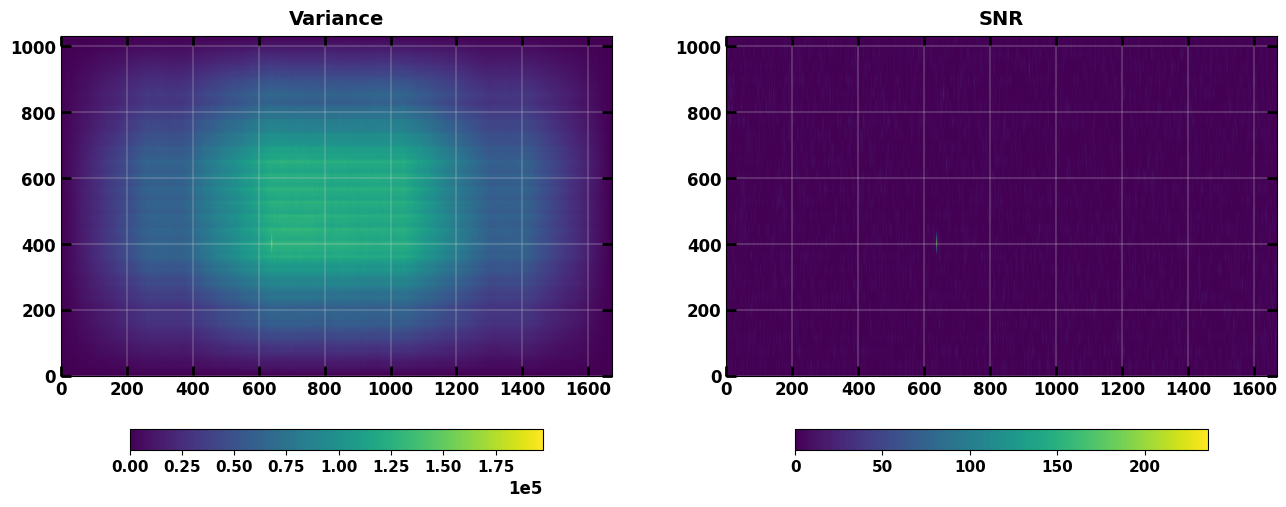

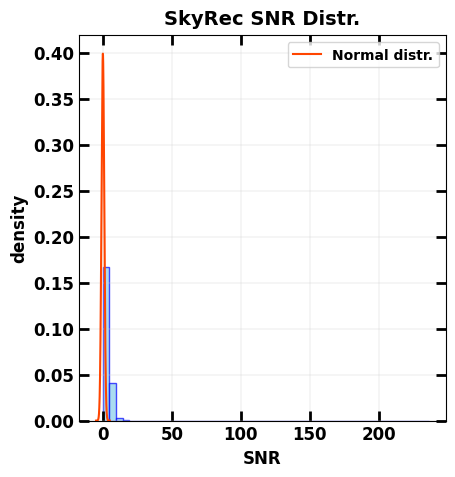

: 

In [ ]:
skyvar = bm.variance(wfm, detector)
skysnr = bm.snratio(skyrec, skyvar)

image_plot([skyvar, skysnr],
           ["Variance", "SNR"],
           cbarlimits=[(None, None), (0, None)])

show_snr_distr = True

if show_snr_distr:
    import numpy as np
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))
    fig.tight_layout()
    ax.hist(skysnr.reshape(-1), bins=50, range=(0, skysnr.max()), density= True,
            color='SkyBlue', edgecolor='b', alpha=0.7)
    ax.plot(x := np.linspace(-5, 5, 1000), np.exp(-0.5*(np.square(x - skysnr.mean())))/np.sqrt(2*np.pi),
            color="OrangeRed", label="Normal distr.")
    ax.set_xlabel("SNR", fontsize=12, fontweight='bold')
    ax.set_ylabel("density", fontsize=12, fontweight='bold')
    ax.set_title(f"SkyRec SNR Distr.",
                    fontsize=14, pad=8, fontweight='bold')
    ax.grid(visible=True, color="lightgray", linestyle="-", linewidth=0.3)
    ax.legend(loc='best')
    ax.tick_params(which='both', direction='in', width=2)
    ax.tick_params(which='major', length=7)
    ax.tick_params(which='minor', length=4)
    ax.xaxis.set_ticks_position('both')
    ax.yaxis.set_ticks_position('both')
    plt.show()

**Composed Cameras**

- Here the Upscaling is needed to ensure the correct superposition of the two cameras:

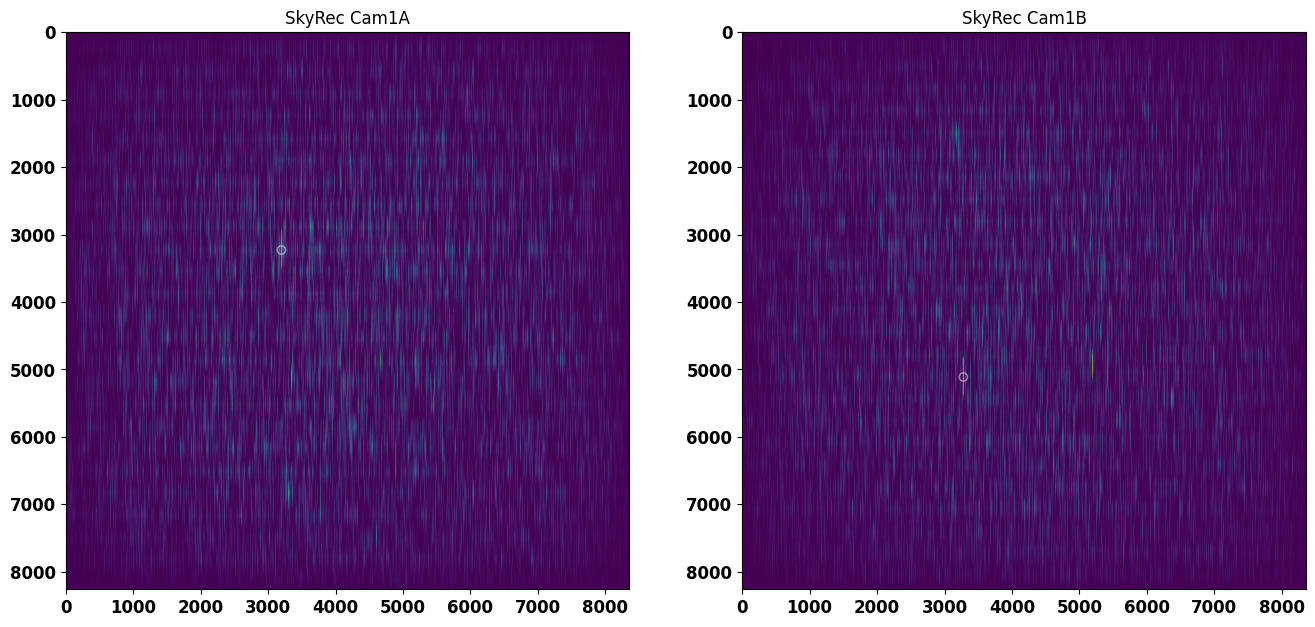

In [3]:
wfm = bm.codedmask(mask_file, upscale_x=5, upscale_y=8)   

sdl_1a = bm.simulation(filepaths["cam1a"]["reconstructed"])
detector_1a, _ = bm.count(wfm, sdl_1a.data)
skyrec_1a = bm.decode(wfm, detector_1a)

# repeat for the second camera
sdl_1b = bm.simulation(filepaths["cam1b"]["reconstructed"])
detector_1b, _ = bm.count(wfm, sdl_1b.data)
skyrec_1b = bm.decode(wfm, detector_1b)

fig, axs = plt.subplots(1, 2, figsize=(16, 9))
for ax, b, bmax, title in zip(
        axs,
        [skyrec_1a, skyrec_1b],
        [bm.images.argmax(skyrec_1a), bm.images.argmax(skyrec_1b)],
        ["SkyRec Cam1A", "SkyRec Cam1B"],
):
    c0 = ax.imshow(b, vmin=0, vmax=-b.min())
    ax.scatter(bmax[1], bmax[0], facecolors='none', edgecolors='white', alpha=0.5)
    ax.set_title(title)
plt.show()

In [4]:
composed_skyrec, composed_f = bm.images.compose(skyrec_1a, skyrec_1b)

In [1]:
%run iros_performance.py

1it [00:24, 24.66s/it]

Iteration 0: ok



2it [00:30, 13.30s/it]

Iteration 1: ok



3it [00:34,  9.50s/it]

Iteration 2: ok



4it [00:39,  7.40s/it]

Iteration 3: ok



5it [00:46,  7.47s/it]

Iteration 4: ok



6it [00:52,  6.90s/it]

Iteration 5: ok



7it [00:59,  8.50s/it]

Iteration 6: ok



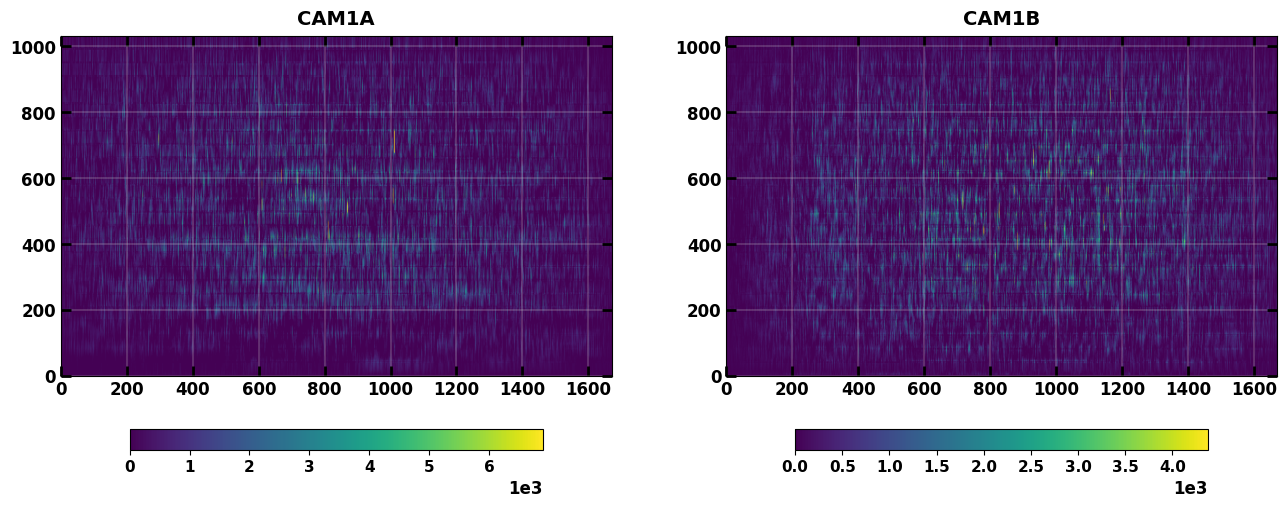

In [8]:
from dummymoon import image_plot

last_res_a = iros_log[cam_a][r][-1]
last_res_b = iros_log[cam_b][r][-1]

image_plot([last_res_a, last_res_b],
           [cam_a.upper(), cam_b.upper()],
           cbarlimits=[(0, np.quantile(last_res_a, 1 - 2 * 10 ** -4)), (0, np.quantile(last_res_b, 1 - 2 * 10 ** -4))])

In [10]:
composed, _ = compose(
        upscale(iros_log[cam_a][r][-1], upscale_x=5, upscale_y=8),
        upscale(iros_log[cam_b][r][-1], upscale_x=5, upscale_y=8),
        strict=False,
        )
    
composed[composed < 0] = 0
composed[composed > np.quantile(composed, 1 - 1e-4)] = 0

In [ ]:
composed.max(), np.quantile(composed, 1 - 2e-4)

(np.float64(60919.35212521007), np.float64(8626.465720780514))

In [10]:
c1 = composed.copy(); c1[c1 > np.quantile(composed, 1 - 1e-4)] = 0
c2 = composed.copy(); c2[c2 > np.quantile(composed, 1 - 2e-4)] = 0
c3 = composed.copy(); c3[c3 > np.quantile(composed, 1 - 4e-4)] = 0

In [13]:
from dummymoon import image_plot

last_res_a = iros_log[cam_a][r][-1]
c = composed.copy(); c[c > last_res_a.max()] = 0

image_plot([c], [f"Composed {cam_a.upper()}-{cam_b.upper()}"])

: 